## 1. Data Processing

In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


## Download data from Kaggle

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d sbaghbidi/human-faces-object-detection

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 70, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1493, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1447, in dataset_download_files
    self.download_file(response, outfile, quiet, not force)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1834, in download_file
    size = int(response.headers['Content-Length'])
  File "/usr/local/lib/python3.10/dist-packages/urllib3/_collections.py", line 258, in __getitem__
    val = self._container[key.lower()]
KeyError: 'content-length'


In [ ]:
# unzip data
!unzip /content/human-faces-object-detection.zip -d human_faces_object_detection

Archive:  /content/human-faces-object-detection.zip
  inflating: human_faces_object_detection/faces.csv  
  inflating: human_faces_object_detection/images/00000003.jpg  
  inflating: human_faces_object_detection/images/00000004.jpg  
  inflating: human_faces_object_detection/images/00000005.jpg  
  inflating: human_faces_object_detection/images/00000006.jpg  
  inflating: human_faces_object_detection/images/00000008.jpg  
  inflating: human_faces_object_detection/images/00000011.jpg  
  inflating: human_faces_object_detection/images/00000012.jpg  
  inflating: human_faces_object_detection/images/00000015.jpg  
  inflating: human_faces_object_detection/images/00000018.jpg  
  inflating: human_faces_object_detection/images/00000020.jpg  
  inflating: human_faces_object_detection/images/00000022.jpg  
  inflating: human_faces_object_detection/images/00000023.jpg  
  inflating: human_faces_object_detection/images/00000024.jpg  
  inflating: human_faces_object_detection/images/00000026.jpg 

In [ ]:
import pandas as pd
faces = pd.read_csv("/content/human_faces_object_detection/faces.csv")
faces.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [ ]:
# define our paths
IMAGES_PATH = "/content/human_faces_object_detection/images"

In [ ]:
# set empty arrays to append data
data = [] # will hold our images
targets = [] # will hold our co-ordinates
filenames = [] # filenames of individual images

IMG_SIZE = (224, 224) # set all images to be a fixed size

for row_no in range(len(faces)):
  (filename,w,h,x0,y0,x1,y1) = faces.loc[row_no]
  x0 = float(x0/w)
  y0 = float(y0/h)
  x1 = float(x1/w)
  y1 = float(y1/h)
  imagePath = os.path.sep.join([IMAGES_PATH, filename])
  image = load_img(imagePath, target_size = IMG_SIZE)
  image = img_to_array(image)
  data.append(image)
  targets.append((x0,y0,x1,y1))
  filenames.append(filename)


In [ ]:
data = np.array(data, dtype = "float32")
targets = np.array(targets, dtype = "float32")

In [ ]:
data.shape, targets.shape

((3350, 224, 224, 3), (3350, 4))

## Split data into train and test sets

In [ ]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.20,
	random_state=42)

In [ ]:
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]


In [ ]:
# create empty text file in the human faces directory to write test images to
with open('/content/human_faces_object_detection/test_images.txt', 'w') as creating_new_csv_file:
   pass
print("Empty File Created Successfully")

In [ ]:
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor

TEST_FILENAMES = "/content/human_faces_object_detection/test_images.txt"
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


## Turn data into PrefetchDataset of batches

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainImages, trainTargets))
test_dataset = tf.data.Dataset.from_tensor_slices((testImages, testTargets))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [ ]:
it = iter(train_dataset)

print(next(it))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [147., 125., 104.],
        [171., 124., 106.],
        ...,
        [ 24.,  21.,  14.],
        [ 21.,  18.,  13.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [158., 110.,  70.],
        [166.,  97.,  55.],
        ...,
        [ 27.,  22.,  16.],
        [ 23.,  18.,  14.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [ 75.,  95.,  34.],
        [109.,  84.,  62.],
        ...,
        [  6.,  31.,  87.],
        [  0.,  23.,  77.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [ 68.,  86.,  28.],
        [ 74.,  88.,  27.],
        ...,
        [  0.,  20.,  73.],
        [  1.,  28.,  81.],
        [255., 255., 255.]],

       [[255., 2

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
it = iter(train_dataset)

print(next(it))

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [147., 125., 104.],
         [171., 124., 106.],
         ...,
         [ 24.,  21.,  14.],
         [ 21.,  18.,  13.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [158., 110.,  70.],
         [166.,  97.,  55.],
         ...,
         [ 27.,  22.,  16.],
         [ 23.,  18.,  14.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [ 75.,  95.,  34.],
         [109.,  84.,  62.],
         ...,
         [  6.,  31.,  87.],
         [  0.,  23.,  77.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [ 68.,  86.,  28.],
         [ 74.,  88.,  27.],
         ...,
         [  0.,  20.,  73.],
         [  1.,  28.,  81.],
       

## 2. Visualising a batch of images and bounding box around faces

In [ ]:
for image, target in train_dataset.take(1):
  for i in range(9):
    print(image[i].shape)

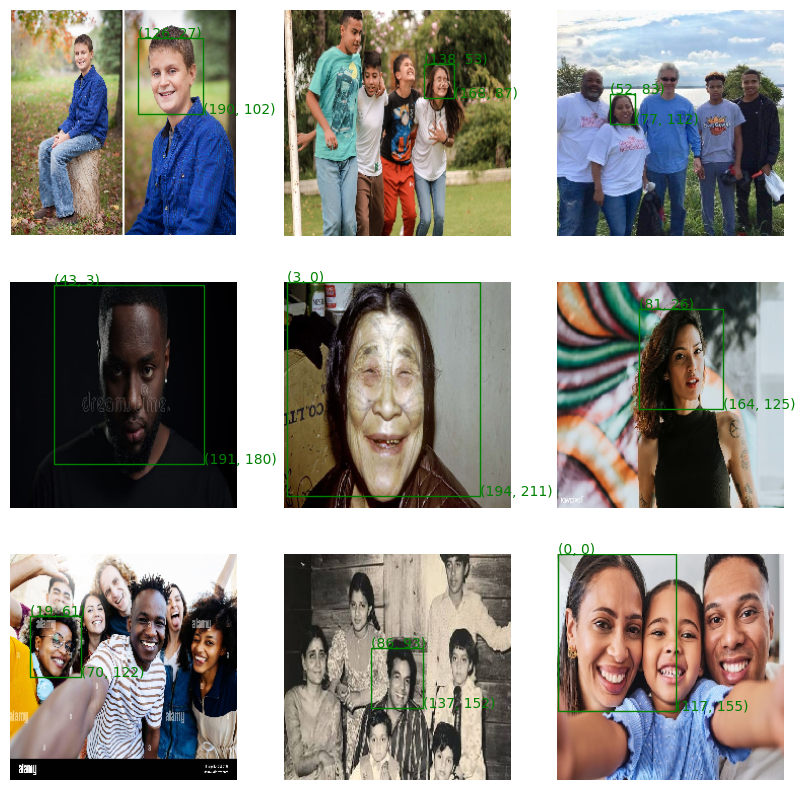

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(10, 10))
for image, target in train_dataset.take(1):
  for i in range(9):
    coords = np.array(target[i])
    dummy_true_boxes = (coords*224).astype(np.int32).clip(min=0, max=225) # we x224 as need to rescale the co-ords. IMG_SIZE = (224,224)

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.annotate(f"{(dummy_true_boxes[0], dummy_true_boxes[1])}", xy = (dummy_true_boxes[0], dummy_true_boxes[1]), color = "g")
    plt.annotate(f"{(dummy_true_boxes[2], dummy_true_boxes[3])}", xy = (dummy_true_boxes[2], dummy_true_boxes[3]), color = "g")
    w = dummy_true_boxes[2] -dummy_true_boxes[0]
    h= dummy_true_boxes[3]-dummy_true_boxes[1]
    rect = Rectangle((dummy_true_boxes[0], dummy_true_boxes[1]), w,h, edgecolor = "g", facecolor = "none")
    ax.add_patch(rect)
    plt.axis("off");

# Build model

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
# compile model
model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.Adam(INIT_LR))

h = model.fit(train_dataset,
          epochs = NUM_EPOCHS,
          validation_data = test_dataset
          )

Epoch 1/10
84/84 [==============================] - 16s 173ms/step - loss: 0.1619 - val_loss: 0.1135
Epoch 2/10
84/84 [==============================] - 14s 170ms/step - loss: 0.1025 - val_loss: 0.0858
Epoch 3/10
84/84 [==============================] - 14s 165ms/step - loss: 0.0721 - val_loss: 0.0612
Epoch 4/10
84/84 [==============================] - 14s 164ms/step - loss: 0.0490 - val_loss: 0.0497
Epoch 5/10
84/84 [==============================] - 14s 164ms/step - loss: 0.0373 - val_loss: 0.0470
Epoch 6/10
84/84 [==============================] - 14s 167ms/step - loss: 0.0332 - val_loss: 0.0495
Epoch 7/10
84/84 [==============================] - 14s 169ms/step - loss: 0.0315 - val_loss: 0.0431
Epoch 8/10
84/84 [==============================] - 14s 168ms/step - loss: 0.0298 - val_loss: 0.0441
Epoch 9/10
84/84 [==============================] - 16s 195ms/step - loss: 0.0268 - val_loss: 0.0388
Epoch 10/10
84/84 [==============================] - 14s 163ms/step - loss: 0.0246 - val_lo

Text(0.5, 1.0, 'MSE Loss v Epoch')

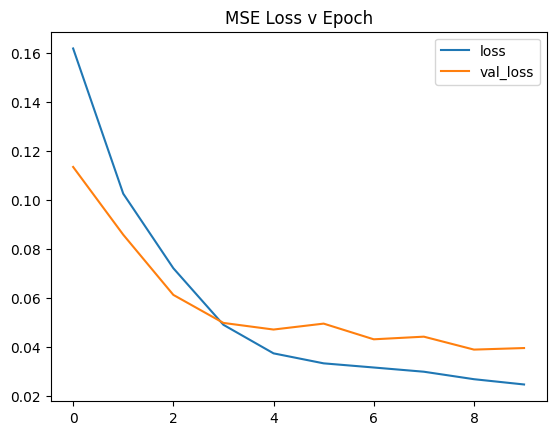

In [ ]:
import pandas as pd
pd.DataFrame(h.history).plot()
plt.title("MSE Loss v Epoch")

Loss curve suggests overfitting happening on test data.

In [ ]:
model.evaluate(test_dataset)

21/21 [==============================] - 3s 133ms/step - loss: 0.0395


0.03948076441884041

In [ ]:
model.save("saved_face_detection_model")

In [ ]:
loaded_model = tf.keras.models.load_model("saved_face_detection_model")
loaded_model.evaluate(test_dataset)

21/21 [==============================] - 3s 135ms/step - loss: 0.0395


0.03948076441884041

## Adding Image Augmentation

In [ ]:
from tensorflow.keras import layers


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.5)
])

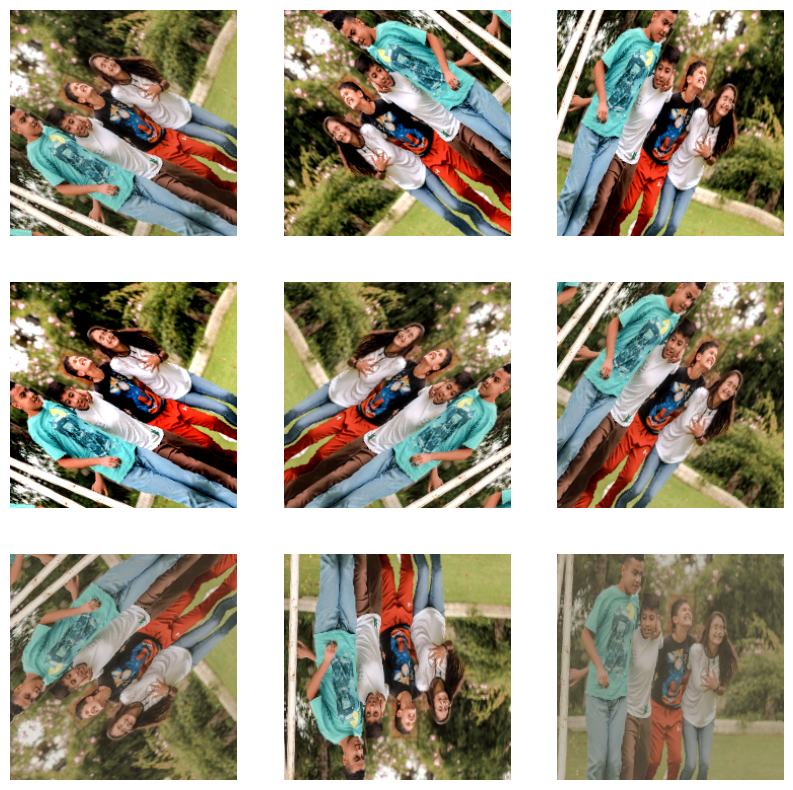

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(10, 10))
for image, target in train_dataset.take(1):
  for i in range(9):
   # coords = np.array(target[i])
   # dummy_true_boxes = (coords*224).astype(np.int32).clip(min=0, max=225) # we x224 as need to rescale the co-ords. IMG_SIZE = (224,224)
    image_augmented = data_augmentation(image[1])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_augmented.numpy().astype("uint8"))
    plt.axis("off");

## Build model with Image Augmentation

In [ ]:
# input layer
inputs=Input(shape=(224, 224, 3))

# data augmentation

augmented_data = data_augmentation(inputs)

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=augmented_data)
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (224, 224, 3)             0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1475

In [ ]:
# compile model
model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.Adam(INIT_LR))

h2 = model.fit(train_dataset,
          epochs = NUM_EPOCHS,
          validation_data = test_dataset
          )

Epoch 1/10
84/84 [==============================] - 19s 206ms/step - loss: 0.1398 - val_loss: 0.1296
Epoch 2/10
84/84 [==============================] - 15s 173ms/step - loss: 0.1204 - val_loss: 0.1255
Epoch 3/10
84/84 [==============================] - 14s 169ms/step - loss: 0.1082 - val_loss: 0.1101
Epoch 4/10
84/84 [==============================] - 14s 166ms/step - loss: 0.0951 - val_loss: 0.0961
Epoch 5/10
84/84 [==============================] - 14s 167ms/step - loss: 0.0838 - val_loss: 0.0853
Epoch 6/10
84/84 [==============================] - 14s 169ms/step - loss: 0.0768 - val_loss: 0.0779
Epoch 7/10
84/84 [==============================] - 14s 171ms/step - loss: 0.0729 - val_loss: 0.0762
Epoch 8/10
84/84 [==============================] - 14s 172ms/step - loss: 0.0710 - val_loss: 0.0739
Epoch 9/10
84/84 [==============================] - 14s 171ms/step - loss: 0.0704 - val_loss: 0.0726
Epoch 10/10
84/84 [==============================] - 14s 168ms/step - loss: 0.0699 - val_lo

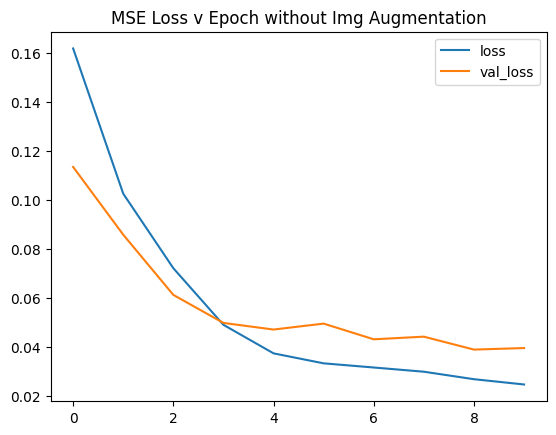

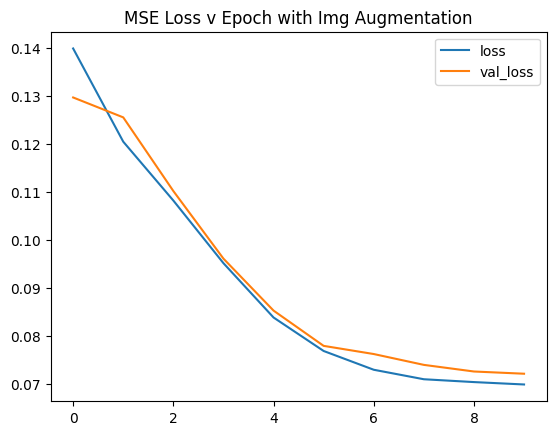

In [ ]:
pd.DataFrame(h.history).plot()
plt.title("MSE Loss v Epoch without Img Augmentation")
pd.DataFrame(h2.history).plot()
plt.title("MSE Loss v Epoch with Img Augmentation");

## 3. Make predictions on an image

In [ ]:
def random_test_prediction(model):
  randindex = random.randint(0, len(testImages))
  image = testImages[randindex]
  title = testFilenames[randindex]
  real_coords = testTargets[randindex]
  pred = model.predict(tf.expand_dims(image,axis = 0))

  dummy_pred_boxes = (pred*224.).astype(np.int32).clip(min=0, max=224)[0]
  fig, ax = plt.subplots()
  ax.imshow(image/255.)
  plt.annotate(f"{(dummy_pred_boxes[0], dummy_pred_boxes[1])}", xy = (dummy_pred_boxes[0], dummy_pred_boxes[1]), color = "r")
  plt.annotate(f"{(dummy_pred_boxes[2], dummy_pred_boxes[3])}", xy = (dummy_pred_boxes[2], dummy_pred_boxes[3]), color = "r")
  w = dummy_pred_boxes[2] -dummy_pred_boxes[0]
  h= dummy_pred_boxes[3]-dummy_pred_boxes[1]
  rect_pred = Rectangle((dummy_pred_boxes[0], dummy_pred_boxes[1]), w,h, edgecolor = "r", facecolor = "none")
  ax.add_patch(rect_pred)

  dummy_true_boxes = (real_coords*224.).astype(np.int32).clip(min=0, max=224)
  plt.annotate(f"{(dummy_true_boxes[0], dummy_true_boxes[1])}", xy = (dummy_true_boxes[0], dummy_true_boxes[1]), color = "g")
  plt.annotate(f"{(dummy_true_boxes[2], dummy_true_boxes[3])}", xy = (dummy_true_boxes[2], dummy_true_boxes[3]), color = "g")
  w = dummy_true_boxes[2] -dummy_true_boxes[0]
  h= dummy_true_boxes[3]-dummy_true_boxes[1]
  rect_true = Rectangle((dummy_true_boxes[0], dummy_true_boxes[1]), w,h, edgecolor = "g", facecolor = "none")
  ax.add_patch(rect_true)

  return dummy_true_boxes

1/1 [==============================] - 1s 757ms/step


array([100,  46, 159, 115], dtype=int32)

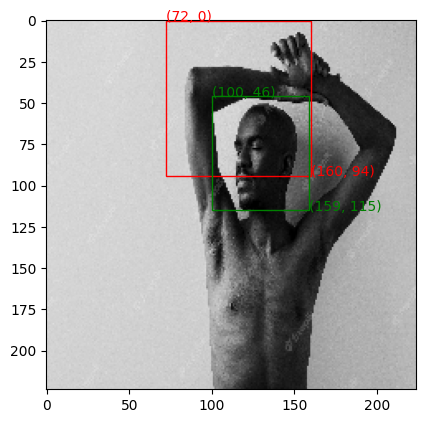

In [ ]:
random_test_prediction(model)